In [29]:
import time
import math

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision as tv
import torch.nn as nn

In [30]:
# Используем Fasion MNIST https://github.com/zalandoresearch/fashion-mnist

BATCH_SIZE=512
LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

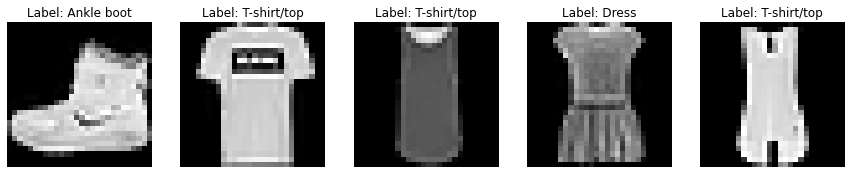

In [31]:
# Поглядим на примеры с лейблами из датасета

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[i]
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {LABELS[label]}')
    axs[i].axis('off')
plt.show()

In [48]:
model = torch.nn.Sequential(
    nn.Conv2d(1, 12, kernel_size=5, padding=0),
    nn.ReLU(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(12, 24, kernel_size=3),
    nn.ReLU(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(24, 160, kernel_size=5),
    torch.nn.Flatten(),
    torch.nn.Linear(160, 80),
    torch.nn.BatchNorm1d(80),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(80, 10)
)

In [49]:
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=.01)
num_epochs = 15

In [50]:
def train_model():
    for ep in range(num_epochs):
        train_iters, train_passed  = 0, 0
        train_loss, train_acc = 0., 0.
        start=time.time()
        
        model.train()
        for X, y in train:
            trainer.zero_grad()
            y_pred = model(X)
            l = loss(y_pred, y)
            l.backward()
            trainer.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_iters += 1
            train_passed += len(X)
        
        test_iters, test_passed  = 0, 0
        test_loss, test_acc = 0., 0.
        model.eval()
        for X, y in test:
            y_pred = model(X)
            l = loss(y_pred, y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_iters += 1
            test_passed += len(X)
            
        print("ep: {}, taked: {:.3f}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
            ep, time.time() - start, round(train_loss / train_iters, 3), round(train_acc / train_passed, 3),
            round(test_loss / test_iters, 3), round(test_acc / test_passed, 3))
        )

In [51]:
train_model()

ep: 0, taked: 11.195, train_loss: 0.602, train_acc: 0.786, test_loss: 0.528, test_acc: 0.801
ep: 1, taked: 11.052, train_loss: 0.41, train_acc: 0.852, test_loss: 0.4, test_acc: 0.858
ep: 2, taked: 11.181, train_loss: 0.361, train_acc: 0.871, test_loss: 0.318, test_acc: 0.883
ep: 3, taked: 11.069, train_loss: 0.332, train_acc: 0.881, test_loss: 0.342, test_acc: 0.87
ep: 4, taked: 11.164, train_loss: 0.321, train_acc: 0.885, test_loss: 0.318, test_acc: 0.888
ep: 5, taked: 11.333, train_loss: 0.307, train_acc: 0.89, test_loss: 0.296, test_acc: 0.893
ep: 6, taked: 11.118, train_loss: 0.296, train_acc: 0.894, test_loss: 0.293, test_acc: 0.89
ep: 7, taked: 11.114, train_loss: 0.289, train_acc: 0.896, test_loss: 0.29, test_acc: 0.894
ep: 8, taked: 11.174, train_loss: 0.285, train_acc: 0.897, test_loss: 0.303, test_acc: 0.894
ep: 9, taked: 11.150, train_loss: 0.281, train_acc: 0.899, test_loss: 0.279, test_acc: 0.899
ep: 10, taked: 11.259, train_loss: 0.268, train_acc: 0.902, test_loss: 0.32, 

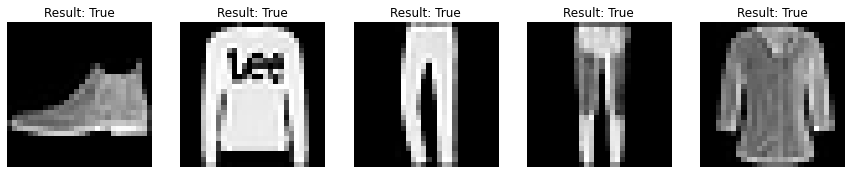

In [52]:
# Несколько примеров как работает модель

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
test_samples = next(iter(test));
predictions = model(test_samples[0]);

for i in range(5):
    label = test_samples[1][i]
    predict = torch.argmax(predictions[i])
    axs[i].imshow(test_samples[0][i].squeeze(), cmap='gray')
    axs[i].set_title(f'Result: {label == predict}')
    axs[i].axis('off')
plt.show()

In [79]:
# Визуализируем несколько первых сверток

def apply_filter(img, filter_):
    img_transformed = torch.clone(img)
    size_x, size_y = img.shape
    padding = math.floor(filter_.shape[0]/2)
    for x in range(padding, size_x-padding):
        for y in range(2, size_y-padding):
            convolution = 0.0

            dimg = img[x-padding:x+padding+1, y-padding:y+padding+1] 
            convolution = torch.sum(dimg * filter_)

            if convolution < 0:
                convolution = 0
            if convolution > 255:
                convolution = 255
            img_transformed[x, y] = convolution
    return img_transformed

layer_weights = [layer.weight.data.numpy() for layer in model if isinstance(layer, torch.nn.Conv2d)]

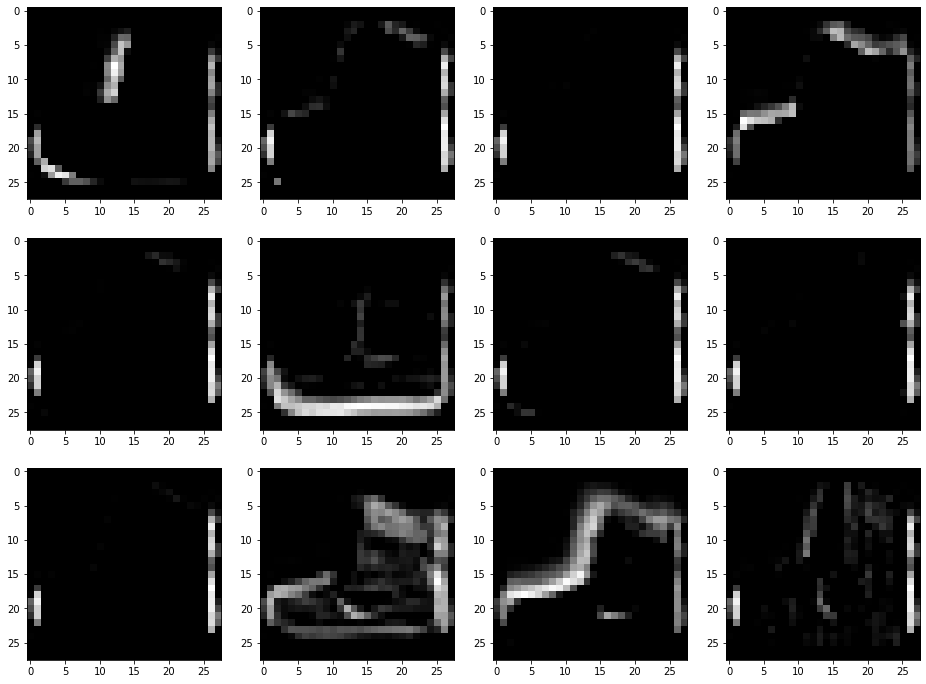

In [80]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
img, label = train_dataset[0]

for i, weights in enumerate(layer_weights[0][0:16]):
    convolution = apply_filter(img[0], weights[0])
    axs[math.floor(i/4)][i % 4].imshow(convolution, cmap='gray', aspect='auto')
plt.show()

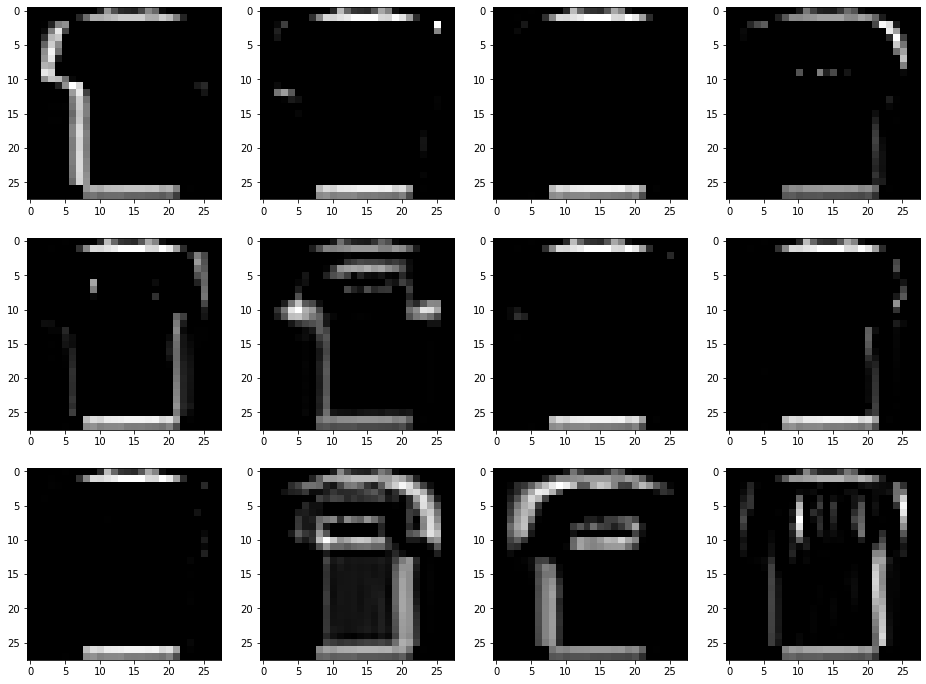

In [81]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
img, label = train_dataset[1]

for i, weights in enumerate(layer_weights[0][0:16]):
    convolution = apply_filter(img[0], weights[0])
    axs[math.floor(i/4)][i % 4].imshow(convolution, cmap='gray', aspect='auto')
plt.show()